In [1]:
import librosa
import scipy.signal as scipy_signal
import numpy as np
import tensorflow as tf
from hmica_learning import HMICALearner, ParallelHMICALearner
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import pandas as pd
import os
from evaluation import signal_to_noise_ratio, signal_to_distortion_ratio
from scipy.io import wavfile as wf

In [2]:
parents = [os.getcwd(), 'mix', '2_speaker_8000_hz']
path = os.path.join(*parents, "2speakers/wav8k/max/cv/mix/01aa010s_0.40678_40ia010v_-0.40678.wav")
path_a = os.path.join(*parents, "2speakers/wav8k/max/cv/s1/01aa010s_0.40678_40ia010v_-0.40678.wav")
path_b = os.path.join(*parents, "2speakers/wav8k/max/cv/s2/01aa010s_0.40678_40ia010v_-0.40678.wav")

mixed_signal, sr = librosa.load(path, sr=None)
source_1, sampling_rate_1 = librosa.load(path_a, sr=None)
source_2, sampling_rate_2 = librosa.load(path_b, sr=None)

In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy_signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, fs, order=55):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scipy_signal.lfilter(b, a, data)
    return y

def high_pass_filter(data, cutoff_freq, fs, order=5):
    """
    Apply a high-pass filter to the audio data.

    :param data: The audio data as a NumPy array.
    :param cutoff_freq: The cutoff frequency of the filter in Hz.
    :param fs: The sampling rate of the audio data in Hz.
    :param order: The order of the filter.
    :return: The filtered audio data.
    """

    nyq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyq
    b, a = scipy_signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = scipy_signal.filtfilt(b, a, data)
    return y

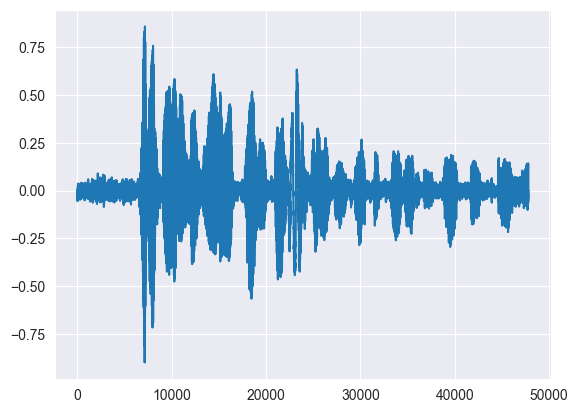

In [4]:
plt.plot(source_1)

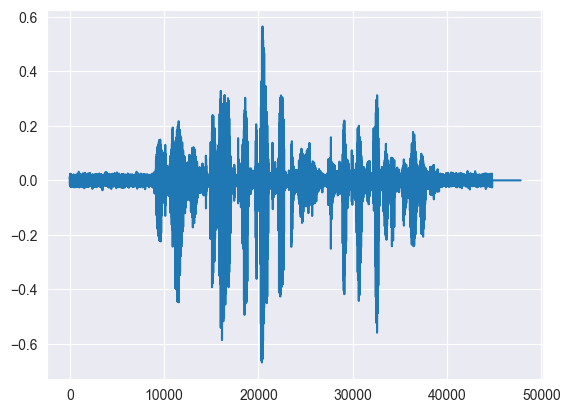

In [5]:
plt.plot(source_2)

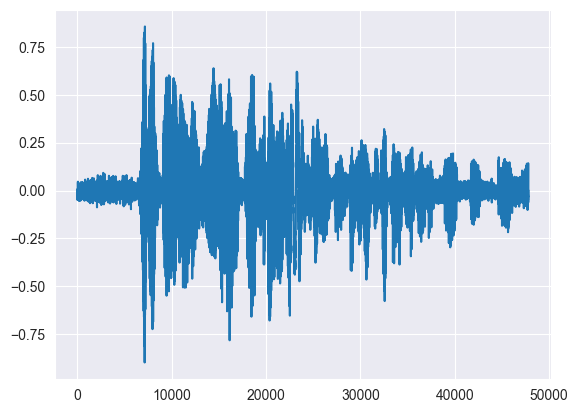

In [6]:
plt.plot(mixed_signal)

In [7]:
source_1.shape, source_2.shape, mixed_signal.shape

((47796,), (47796,), (47796,))

### Low and high pass filter to remove high frequency noise and low frequency noise

In [8]:
# source_1 = high_pass_filter(source_1, 300, sampling_rate_1) 
# source_2 = high_pass_filter(source_2, 300, sampling_rate_2)
# mixed_signal = high_pass_filter(mixed_signal, 300, sr)

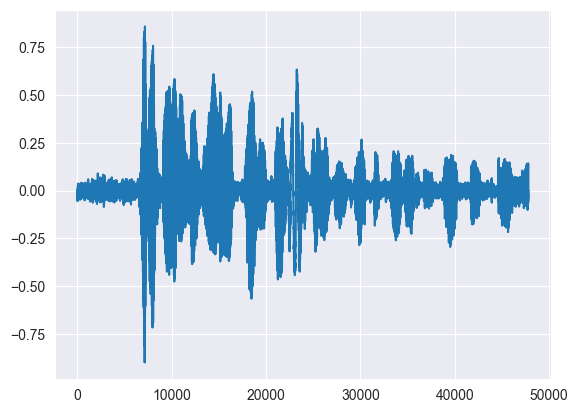

In [9]:
plt.plot(source_1)

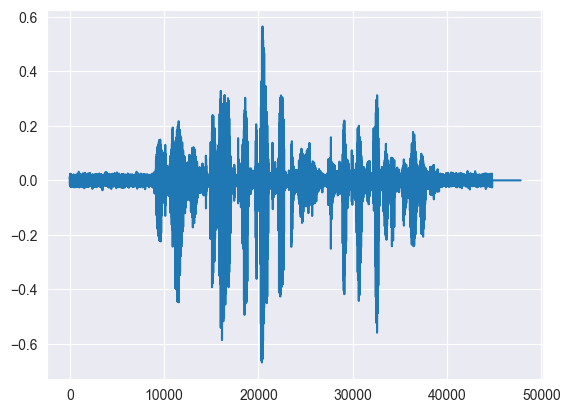

In [10]:
plt.plot(source_2)

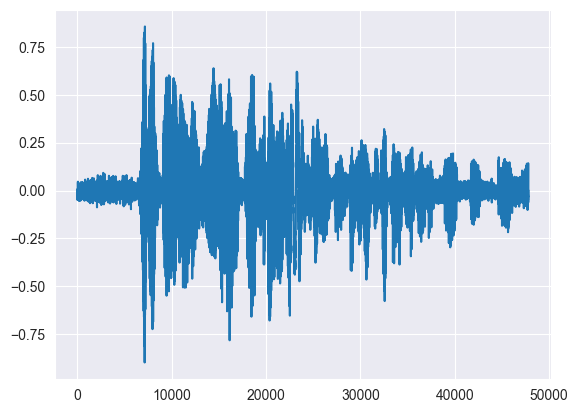

In [11]:
plt.plot(mixed_signal)

In [12]:
Audio(mixed_signal, rate=sr)

In [13]:
Audio(source_1, rate=sampling_rate_1)

In [14]:
Audio(source_2, rate=sampling_rate_2)

In [15]:
mixing_matrix = np.array([[0.6, 0.4], 
                          [0.2, 0.8]])
tmp = np.vstack((source_1, source_2))
x = mixing_matrix @ tmp 
# x = np.vstack((mixed_tmp, mixed_signal))
Audio(x, rate=sr)

In [16]:
source_1, sampling_rate_1, source_2, sampling_rate_2, tmp

(array([-0.01318359, -0.01229858, -0.01986694, ...,  0.0206604 ,
         0.00637817,  0.00152588], dtype=float32),
 8000,
 array([-0.01596069, -0.01544189, -0.00222778, ...,  0.        ,
         0.        ,  0.        ], dtype=float32),
 8000,
 array([[-0.01318359, -0.01229858, -0.01986694, ...,  0.0206604 ,
          0.00637817,  0.00152588],
        [-0.01596069, -0.01544189, -0.00222778, ...,  0.        ,
          0.        ,  0.        ]], dtype=float32))

### STFT: (Skip)

In [17]:
nperseg = 128
f, t, Zxx = scipy_signal.stft(mixed_signal, fs=sr, nperseg=nperseg, noverlap=None)
print(f'{f.shape=}, {t.shape=}, {Zxx.shape=}')

f.shape=(65,), t.shape=(748,), Zxx.shape=(65, 748)


In [18]:
# step2 - converting audio np array to spectrogram
spec = librosa.feature.melspectrogram(y=mixed_signal,
                                        sr=sr,)

In [19]:
res = librosa.feature.inverse.mel_to_audio(spec,
                                           sr=sr,)

In [20]:
Audio(res, rate=sr)

In [21]:
Audio(mixed_signal, rate=sr)

In [22]:
res[0], mixed_signal[0]

(np.float32(-0.018896732), np.float32(-0.029144287))

In [23]:

t2, x_hat = scipy_signal.istft(Zxx.real, fs=sr, nperseg=nperseg, noverlap=None)
print(f'{t2.shape=}, {x_hat.shape=}')

t2.shape=(47808,), x_hat.shape=(47808,)


In [24]:
Audio(x_hat, rate=sr)

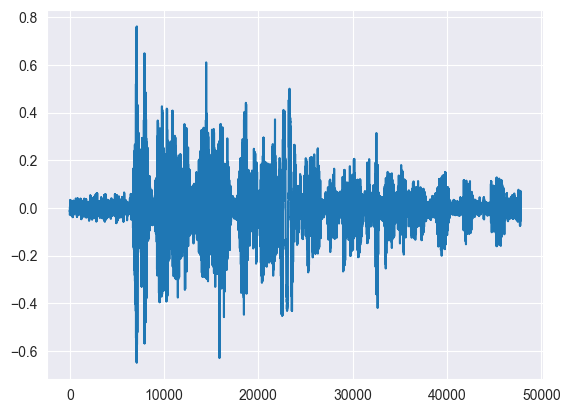

In [25]:
plt.plot(x_hat)

### HMICA

In [26]:
x.shape[0]

2

In [27]:
A_6_states = [
 [0.6500, 0.0700, 0.0700, 0.0700, 0.0700, 0.0700],
 [0.0700, 0.6500, 0.0700, 0.0700, 0.0700, 0.0700],
 [0.0700, 0.0700, 0.6500, 0.0700, 0.0700, 0.0700],
 [0.0700, 0.0700, 0.0700, 0.6500, 0.0700, 0.0700],
 [0.0700, 0.0700, 0.0700, 0.0700, 0.6500, 0.0700],
 [0.0700, 0.0700, 0.0700, 0.0700, 0.0700, 0.6500]]

A_4_states = [[0.6500, 0.1167, 0.1167, 0.1167],
 [0.1167, 0.6500, 0.1167, 0.1167],
 [0.1167, 0.1167, 0.6500, 0.1167],
 [0.1167, 0.1167, 0.1167, 0.6500]]

A_8_states = [[0.13973027, 0.13386568, 0.13333714, 0.13579208, 0.13440694,
        0.13308887, 0.13287611, 0.13465291],
       [0.10412742, 0.10859548, 0.10476808, 0.10534154, 0.10914522,
        0.10521875, 0.1044198 , 0.10627869],
       [0.15078655, 0.14964223, 0.15259674, 0.15167394, 0.1481522 ,
        0.15222692, 0.1506204 , 0.15044487],
       [0.15105721, 0.1505694 , 0.15021652, 0.15339789, 0.14988999,
        0.14975987, 0.14919956, 0.1477967 ],
       [0.09530228, 0.10013262, 0.09421756, 0.09487449, 0.10268576,
        0.09485968, 0.09501221, 0.09690556],
       [0.11948916, 0.11957914, 0.12241231, 0.12058465, 0.11836839,
        0.12351974, 0.11987699, 0.12036941],
       [0.10394578, 0.10263647, 0.10381163, 0.10242771, 0.1045389 ,
        0.10377071, 0.10928903, 0.10461909],
       [0.13332498, 0.1355698 , 0.13738528, 0.13381632, 0.13534361,
        0.13809963, 0.1402599 , 0.14091428]]


hmica = ParallelHMICALearner(
    k=5,  # number of states;  No-one, speaker 1, speaker 2 and both speakers (doubled to try to capture more acoustic information)
    m=2,  # number of sources
    x_dims=x.shape[0],
    use_gar=False,
    gar_order=10, # p = 8to12 should cover 1-1.5ms of speech context Speech has short-term correlations that span roughly 2-3ms
    update_interval=5,  # suggested by the paper
    learning_rates={
        'W': 1e-4,  # Unmixing matrix
        'R': 1e-3,  # Shape parameter
        'beta': 1e-3,  # Scale parameter
        'C': 1e-3  # GAR coefficients
    },
    use_analytical=False,
    # A = tf.convert_to_tensor(A_8_states)
)

history = hmica.train(tf.convert_to_tensor(x.astype('float32').T)
                      , hmm_max_iter=25, ica_max_iter=5000, hmm_tol=1e-6, ica_tol=1e-4)

  0%|          | 0/25 [00:00<?, ?it/s]

Function _compute_total_likelihood Took 0.0435 seconds


  4%|▍         | 1/25 [00:46<18:41, 46.72s/it]

Function _update_hmm_parameters Took 0.0293 seconds
Function _compute_total_likelihood Took 0.0318 seconds


  8%|▊         | 2/25 [01:33<17:51, 46.57s/it]

Function _update_hmm_parameters Took 0.0340 seconds
Function _compute_total_likelihood Took 0.0475 seconds


 12%|█▏        | 3/25 [02:18<16:49, 45.88s/it]

Function _update_hmm_parameters Took 0.0217 seconds
Function _compute_total_likelihood Took 0.0256 seconds


 16%|█▌        | 4/25 [03:11<17:01, 48.66s/it]

Function _update_hmm_parameters Took 0.0201 seconds
Function _compute_total_likelihood Took 0.0296 seconds


 20%|██        | 5/25 [04:00<16:15, 48.80s/it]

Function _update_hmm_parameters Took 0.0299 seconds
Function _compute_total_likelihood Took 0.0380 seconds


 24%|██▍       | 6/25 [04:33<13:46, 43.48s/it]

Function _update_hmm_parameters Took 0.0188 seconds
Function _compute_total_likelihood Took 0.0249 seconds


 28%|██▊       | 7/25 [05:02<11:35, 38.63s/it]

Function _update_hmm_parameters Took 0.0285 seconds
Function _compute_total_likelihood Took 0.0269 seconds


 32%|███▏      | 8/25 [05:27<09:44, 34.39s/it]

Function _update_hmm_parameters Took 0.0168 seconds
Function _compute_total_likelihood Took 0.0256 seconds


 36%|███▌      | 9/25 [05:53<08:30, 31.92s/it]

Function _update_hmm_parameters Took 0.0180 seconds
Function _compute_total_likelihood Took 0.0240 seconds


 40%|████      | 10/25 [06:21<07:37, 30.52s/it]

Function _update_hmm_parameters Took 0.0168 seconds
Function _compute_total_likelihood Took 0.0232 seconds


 44%|████▍     | 11/25 [06:44<06:37, 28.38s/it]

Function _update_hmm_parameters Took 0.0176 seconds
Function _compute_total_likelihood Took 0.0253 seconds


 48%|████▊     | 12/25 [07:06<05:44, 26.50s/it]

Function _update_hmm_parameters Took 0.0186 seconds
Function _compute_total_likelihood Took 0.0271 seconds


 52%|█████▏    | 13/25 [07:29<05:02, 25.22s/it]

Function _update_hmm_parameters Took 0.0150 seconds
Function _compute_total_likelihood Took 0.0227 seconds


 56%|█████▌    | 14/25 [07:51<04:26, 24.23s/it]

Function _update_hmm_parameters Took 0.0208 seconds
Function _compute_total_likelihood Took 0.0261 seconds


 60%|██████    | 15/25 [08:13<03:57, 23.74s/it]

Function _update_hmm_parameters Took 0.0183 seconds
Function _compute_total_likelihood Took 0.0258 seconds


 64%|██████▍   | 16/25 [08:36<03:29, 23.30s/it]

Function _update_hmm_parameters Took 0.0151 seconds
Function _compute_total_likelihood Took 0.0228 seconds


 68%|██████▊   | 17/25 [08:57<03:02, 22.86s/it]

Function _update_hmm_parameters Took 0.0154 seconds
Function _compute_total_likelihood Took 0.0274 seconds


 72%|███████▏  | 18/25 [09:20<02:38, 22.71s/it]

Function _update_hmm_parameters Took 0.0409 seconds
Function _compute_total_likelihood Took 0.0297 seconds


 76%|███████▌  | 19/25 [09:43<02:16, 22.78s/it]

Function _update_hmm_parameters Took 0.0175 seconds
Function _compute_total_likelihood Took 0.0255 seconds


 80%|████████  | 20/25 [10:05<01:52, 22.49s/it]

Function _update_hmm_parameters Took 0.0169 seconds
Function _compute_total_likelihood Took 0.0233 seconds


 84%|████████▍ | 21/25 [10:27<01:30, 22.52s/it]

Function _update_hmm_parameters Took 0.0543 seconds
Function _compute_total_likelihood Took 0.0437 seconds


 88%|████████▊ | 22/25 [10:50<01:07, 22.56s/it]

Function _update_hmm_parameters Took 0.0185 seconds
Function _compute_total_likelihood Took 0.0263 seconds


 92%|█████████▏| 23/25 [11:12<00:44, 22.39s/it]

Function _update_hmm_parameters Took 0.0223 seconds
Function _compute_total_likelihood Took 0.0328 seconds


 96%|█████████▌| 24/25 [11:34<00:22, 22.41s/it]

Function _update_hmm_parameters Took 0.0158 seconds
Function _compute_total_likelihood Took 0.0235 seconds


100%|██████████| 25/25 [11:56<00:00, 28.64s/it]

Function _update_hmm_parameters Took 0.0160 seconds
Function _compute_total_likelihood Took 0.0238 seconds
Converged ICA 2 in 940 iterations
Converged ICA 0 in 1515 iterations
Converged ICA 0 in 660 iterations
Converged ICA 1 in 5 iterations
Converged ICA 4 in 518 iterations
Converged ICA 2 in 5 iterations
Converged ICA 0 in 12 iterations
Converged ICA 2 in 5 iterations
Converged ICA 0 in 5 iterations
Converged ICA 3 in 5 iterations
Converged ICA 0 in 5 iterations
Converged ICA 3 in 5 iterations
Converged ICA 3 in 5 iterations
Converged ICA 1 in 5 iterations
Converged ICA 3 in 5 iterations
Converged ICA 1 in 1072 iterations
Converged ICA 2 in 1078 iterations
Converged ICA 3 in 717 iterations
Converged ICA 0 in 188 iterations
Converged ICA 1 in 5 iterations
Converged ICA 0 in 5 iterations
Converged ICA 4 in 5 iterations
Converged ICA 3 in 5 iterations
Converged ICA 1 in 5 iterations
Converged ICA 4 in 5 iterations
Converged ICA 2 in 5 iterations
Converged ICA 1 in 5 iterations
Converged

Text(0, 0.5, 'Log Likelihood')

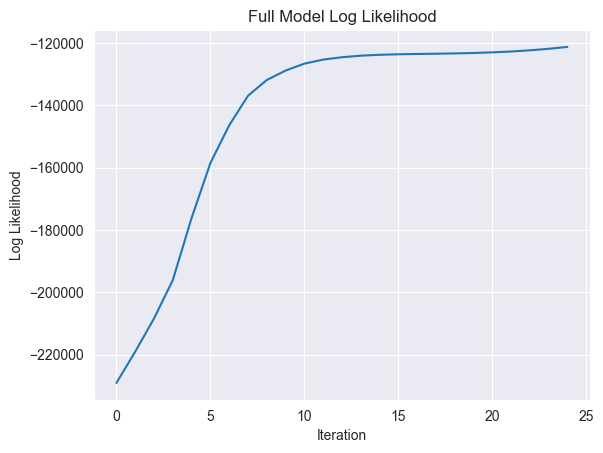

In [28]:
sns.lineplot(x=range(len(history['hmm_ll'])), y=history['hmm_ll'])

# Set the title and labels
plt.title("Full Model Log Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")

Text(0, 0.5, 'Log Likelihood')

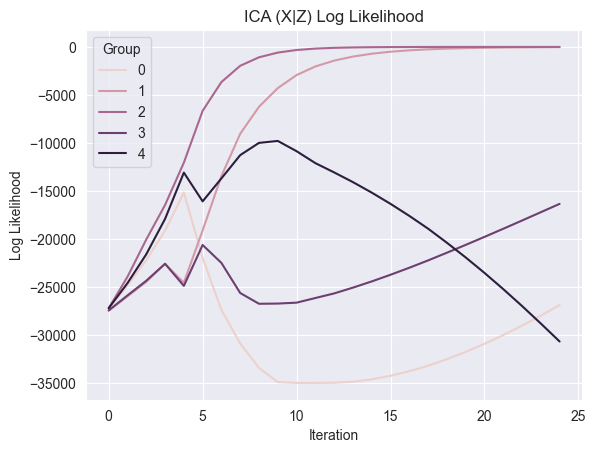

In [29]:
df_list = []
for group, values in history['ica_ll'].items():
    temp_df = pd.DataFrame({
        'Group': group,
        'Value': values,
        'Index': range(len(values))
    })
    df_list.append(temp_df)    
df = pd.concat(df_list, ignore_index=True)

sns.lineplot(data=df, x='Index', y='Value', hue='Group')

# Set the title and labels
plt.title("ICA (X|Z) Log Likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")

In [30]:
obs_prob = lambda state, x: hmica.ica.compute_likelihood(x, state)
state_sequence, w_matrix = hmica.hmm.viterbi_for_inference(tf.convert_to_tensor(x.astype('float32').T), obs_prob)

In [31]:
sources_k = [hmica.ica.get_sources(tf.convert_to_tensor(x.astype('float32').T), k) for k in range(hmica.k)] 
sources_stacked = tf.stack(sources_k) 

In [32]:
reconstructed_sources = tf.einsum('tk,ktn->tn', state_sequence, sources_stacked)
reconstructed_sources = tf.transpose(reconstructed_sources)

In [44]:
Audio(reconstructed_sources[0].numpy(), rate=sr)
wf.write('ngs1_predicted.wav', sampling_rate_1, reconstructed_sources[0].numpy().astype(np.float32))

In [45]:
Audio(reconstructed_sources[1].numpy(), rate=sr)
wf.write('ngs2_predicted.wav', sampling_rate_2, reconstructed_sources[1].numpy().astype(np.float32))


In [35]:
tf.reduce_sum(state_sequence, axis=0)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([    0.,     0.,     0.,     0., 47796.], dtype=float32)>

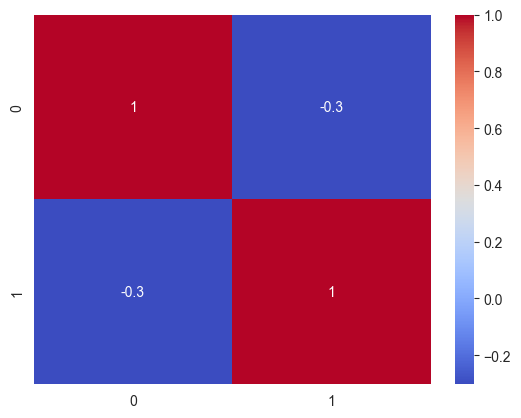

In [36]:
# Correlation between estimated Source
corr_matrix = np.corrcoef(reconstructed_sources.numpy())

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

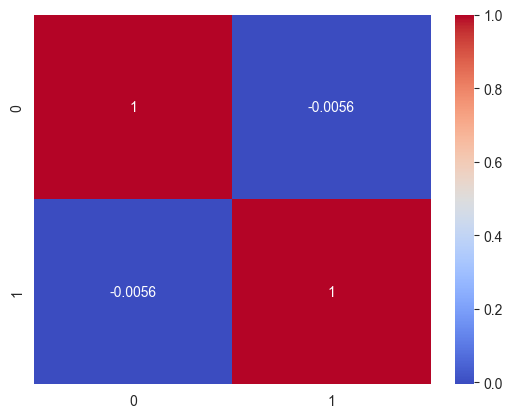

In [37]:
# Correlation between true Source
corr_matrix = np.corrcoef(tmp)

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [38]:
hmica.ica.W

[<tf.Variable 'unmixing_matrices_0:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.00415313, -0.01133443],
        [-0.01133443, -0.00395312]], dtype=float32)>,
 <tf.Variable 'unmixing_matrices_1:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.07590888,  0.222171  ],
        [ 0.22737108,  0.07290933]], dtype=float32)>,
 <tf.Variable 'unmixing_matrices_2:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.5560097 , -0.18925372],
        [-0.17004743,  0.56800777]], dtype=float32)>,
 <tf.Variable 'unmixing_matrices_3:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.00643966,  0.01125035],
        [ 0.01825035,  0.01063968]], dtype=float32)>,
 <tf.Variable 'unmixing_matrices_4:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.01192432, -0.00436209],
        [-0.00416225,  0.01192432]], dtype=float32)>]

In [39]:
hmica.hmm.transition_matrix, hmica.hmm.pi

(<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
 array([[5.4451853e-01, 2.3967725e-04, 2.8104275e-06, 1.6874856e-01,
         2.8649038e-01],
        [3.5527992e-01, 7.5443304e-04, 3.1225188e-06, 2.3864338e-01,
         4.0531912e-01],
        [3.5414284e-01, 3.7724659e-04, 4.5124539e-06, 2.3810999e-01,
         4.0736544e-01],
        [2.7948818e-01, 2.6650960e-04, 2.8827515e-06, 4.0320641e-01,
         3.1703603e-01],
        [2.4235457e-01, 2.3181038e-04, 2.7355466e-06, 1.6186890e-01,
         5.9554195e-01]], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.2271761 , 0.16842464, 0.16838136, 0.20042266, 0.23559526],
       dtype=float32)>)

In [40]:
tf.reduce_sum(hmica.hmm.pi)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [41]:

original_sources = tf.convert_to_tensor(np.vstack((source_1, source_2)))
snr = signal_to_noise_ratio(tf.transpose(original_sources), tf.transpose(reconstructed_sources))
snr


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.00086121,  0.00013585], dtype=float32)>

In [42]:
sdr = signal_to_distortion_ratio(tf.transpose(original_sources), tf.transpose(reconstructed_sources))
sdr

array([ 7.852101, 22.61492 ], dtype=float32)

## ICA

In [45]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components=2,
        random_state=0,
        whiten=False)

In [46]:
reconstructed_sources2 = transformer.fit_transform(x.astype('float32').T)
reconstructed_sources2 /= np.max(np.abs(reconstructed_sources2), axis=0) # Rescale the output to audio range (-1 to 1)

/Users/einsteinoyewole/PycharmProjects/ds-ga1018_project/code/.venv/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:589: UserWarning: Ignoring n_components with whiten=False.
  warnings.warn("Ignoring n_components with whiten=False.")


In [47]:
print(reconstructed_sources2.shape)
assert True, "Stop"

(47796, 2)


In [48]:
wf.write('ics1_predicted.wav', sampling_rate_1, reconstructed_sources2[:, 0].astype(np.float32))
# Audio(reconstructed_sources2[:, 1], rate=sr)

In [49]:
wf.write('ics2_predicted.wav', sampling_rate_2, reconstructed_sources2[:, 1].astype(np.float32))

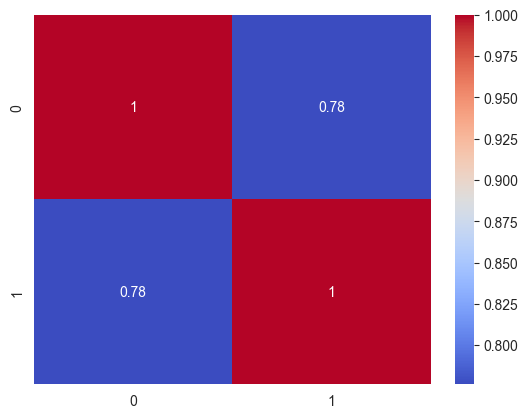

In [50]:
# Correlation between estimated Source
corr_matrix = np.corrcoef(reconstructed_sources2.T)

# Create the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

In [51]:
original_sources = tf.convert_to_tensor(np.vstack((source_2, source_1)))
# reconstructed_sources2 = tf.convert_to_tensor(reconstructed_sources2.astype(np.float32))
snr = signal_to_noise_ratio(tf.transpose(original_sources), reconstructed_sources2)
snr

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.07851239, -0.08454943], dtype=float32)>

In [52]:
reconstructed_sources2.shape

(47796, 2)

In [53]:

sdr = signal_to_distortion_ratio(tf.transpose(original_sources), reconstructed_sources2)
sdr

array([ 1.6031609, 14.032379 ], dtype=float32)

In [26]:
print(sdr)

[14.032345   1.6031628]
